# Todo:
* Parallelise where evr possible
* using category2

## Pipeline

In [21]:
import pandas as pd 
import os
import glob
from sklearn.model_selection import train_test_split
from datetime import datetime

# Mac local path
root_path =  r'/Users/krish/ljmu/1.data/afo/'

In [22]:
len(glob.glob(root_path+'images/*.jpg'))

3641

### Using the train csv to tile and train 

In [23]:
from pathlib import Path
from PIL import Image
import numpy as np
from shapely.geometry import Polygon, Point

In [24]:
train_df = pd.read_csv(root_path + 'images/train.csv')
test_df = pd.read_csv(root_path + 'images/test.csv')

## Model fitting

**Without tiling**

In [25]:
result_root = r'/Users/krish/ljmu/3.results/30112022-parallel-resnet50-500X500-category2/'
Path(result_root).mkdir(parents=True, exist_ok=True)

In [26]:
from tensorflow.keras import layers
from keras_preprocessing.image import ImageDataGenerator

In [27]:
actual_train = pd.read_csv(root_path+'images/train.csv')

In [28]:
actual_train['humans'] = actual_train.humans.apply(lambda x: str(x))

In [29]:
import tensorflow as tf

from tensorflow.keras.layers import Input , Dense , Flatten , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

**using tiling data**

In [30]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv4/train/false/*.jpg')
df_false.humans = 0

tiled_train = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_60799/2699722963.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_train = df_true.append(df_false)


In [31]:
tiled_train['humans'] = tiled_train.humans.apply(lambda x: str(x))

In [32]:
tiled_train

,file_name,humans
0,/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/...,1
1,/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/...,1
2,/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/...,1
3,/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/...,1
4,/Users/krish/ljmu/1.data/afo/tiledv4/train/ts/...,1
...,...,...
80972,/Users/krish/ljmu/1.data/afo/tiledv4/train/fal...,0
80973,/Users/krish/ljmu/1.data/afo/tiledv4/train/fal...,0
80974,/Users/krish/ljmu/1.data/afo/tiledv4/train/fal...,0
80975,/Users/krish/ljmu/1.data/afo/tiledv4/train/fal...,0


In [33]:
train_df, valid_df = train_test_split(tiled_train, 
                                   test_size = 0.15, 
                                   random_state = 1998,
                                   stratify = tiled_train['humans']) # Stratify makes sure that the subset of training and testing data returned keeps the same class propotion of the main dataframe
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 82572 validation 14572


In [34]:
# Rotation_range - random rotation within the angle mentioned
# Random_shifts - shifts 20% at max. to the horizontal and vertical(reduce to 10% as already diverse data)
# Random_flip - random flips 
# fill_mode - fill the blank pixels, when augmenting with the nearest color
datagen = ImageDataGenerator(rotation_range = 360,
                             width_shift_range=0.1, height_shift_range=0.1,
                             #horizontal_flip=True, vertical_flip=True, # Isnt much useful for us
                             brightness_range=[0.5,1.5],
                             rescale=1./255.,fill_mode='nearest')

train_generator = datagen.flow_from_dataframe(dataframe=train_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)
valid_generator = datagen.flow_from_dataframe(dataframe=valid_df, x_col = 'file_name', y_col = 'humans', class_mode='binary', target_size=(224 , 224), batch_size=24)

Found 82572 validated image filenames belonging to 2 classes.
Found 14572 validated image filenames belonging to 2 classes.


In [35]:
# Why I have this as false : https://stackoverflow.com/questions/46036522/defining-model2-in-keras-include-top-true
# So that I can list out the number of classes that I have

vgg_16 = tf.keras.applications.resnet50.ResNet50(input_shape=(224 , 224, 3),
                                           include_top=False, 
                                           weights='imagenet')

model2 = Sequential()
model2.add(vgg_16)
model2.add(GlobalAveragePooling2D())
model2.add(Flatten())
model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))

model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))

model2.add(Dense(1024, activation="relu"))
model2.add(Dense(512, activation="relu"))



model2.add(Dense(1, activation="sigmoid" , name="classification"))

In [36]:
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.004,momentum=0.9), 
            loss='BinaryCrossentropy',
            metrics = ['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 1024)              525312    
                                                      

In [37]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta = 0.5)

In [38]:
class_weight = {0:train_df['humans'].value_counts()[0]/train_df.shape[0],1:train_df['humans'].value_counts()[1]/train_df.shape[0],}

In [39]:
history2 = model2.fit(train_generator, validation_data = valid_generator, epochs = 10, class_weight=class_weight,callbacks=[es])

Epoch 1/10


2022-11-30 17:03:49.960316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3441/3441 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9234

2022-11-30 18:04:51.001058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3441/3441 [==============================] - 3887s 1s/step - loss: 0.0470 - accuracy: 0.9234 - val_loss: 0.2078 - val_accuracy: 0.9305
Epoch 2/10
3441/3441 [==============================] - 4208s 1s/step - loss: 0.0361 - accuracy: 0.9458 - val_loss: 0.1820 - val_accuracy: 0.9425
Epoch 3/10
3441/3441 [==============================] - 4462s 1s/step - loss: 0.0329 - accuracy: 0.9507 - val_loss: 0.1545 - val_accuracy: 0.9548
Epoch 4/10
3441/3441 [==============================] - 4558s 1s/step - loss: 0.0312 - accuracy: 0.9526 - val_loss: 0.1673 - val_accuracy: 0.9465


In [40]:
now = datetime.now()
date_time = now.strftime("%d%m%Y-%H%M")
model_save_dir = result_root+date_time+'-ResNet+tile+augmentation_10epochs_afo_500X500_category2'
model2.save(model_save_dir)

INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/30112022-parallel-resnet50-500X500-category2/30112022-2149-ResNet+tile+augmentation_10epochs_afo_500X500_category2/assets


INFO:tensorflow:Assets written to: /Users/krish/ljmu/3.results/30112022-parallel-resnet50-500X500-category2/30112022-2149-ResNet+tile+augmentation_10epochs_afo_500X500_category2/assets


**I am not sure how I got 75 auc score for model 1. The paper got only 40ish. maybe is it because of any augmentation at all** 
#### Model3 without any augmentation

## Metrics


In [51]:
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
import matplotlib.pyplot as plt

In [52]:
slice_size = 500
newpath = '/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/'

falsepath = '/Users/krish/ljmu/1.data/afo/tiledv4/test/false/'
#creating a new directory called pythondirectory
Path(newpath).mkdir(parents=True, exist_ok=True)
Path(falsepath).mkdir(parents=True, exist_ok=True)

def tiler3(imname):
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    labname = imname.split('/')[-1].replace('.jpg', '.txt')
    labels = pd.read_csv(root_path+'2categories/'+labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
    labels = labels[labels['class']==0] # Only taking into consideration small objects
    
    # we need to rescale coordinates from 0-1 to real image height and width
    labels[['x1', 'w']] = labels[['x1', 'w']] * width
    labels[['y1', 'h']] = labels[['y1', 'h']] * height
    
    boxes = []
    #print(labels)
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    fig, axs = plt.subplots((height // slice_size)+int(bool(height%slice_size)),(width // slice_size)+int(bool(width%slice_size)))    
    for i in range((height // slice_size)+int(bool(height%slice_size))):
        for j in range((width // slice_size)+int(bool(width%slice_size))):
            
            if (i == (height // slice_size)) and (j != (width//slice_size)):
                sliced = imr[height - slice_size:height, j*slice_size:(j+1)*slice_size]
                x1 = width - slice_size
                y1 = height - (i*slice_size)
                x2 = width
                y2 = (height - (i+1)*slice_size) + 1
                
            elif (i != (height // slice_size)) and (j == (width//slice_size)):
                sliced = imr[i*slice_size:(i+1)*slice_size, width - slice_size:width]
                x1 = j*slice_size
                y1 = height - (height - slice_size)
                x2 = ((j+1)*slice_size) - 1
                y2 = 0
                
            elif (i == (height // slice_size)) and (j == (width//slice_size)):
                sliced = imr[height - slice_size:height, width - slice_size:width]
                x1 = width - slice_size
                y1 = height - (height - slice_size)
                x2 = width
                y2 = 0
            
            elif (i != (height // slice_size)) and (j != (width//slice_size)) :
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                x1 = j*slice_size
                y1 = height - (i*slice_size)
                x2 = ((j+1)*slice_size) - 1
                y2 = (height - (i+1)*slice_size) + 1
            
            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []
            
            
            
            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                      
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        ##filename = imname
                        slice_path = newpath + filename.replace('.jpg', f'_{i}_{j}.jpg')
                        
                        slice_labels_path = newpath + filename.replace('.jpg', f'_{i}_{j}.txt')
                        
                        print(slice_path)
                        #print('hi')
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
                    
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                #print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[-1]
                #filename = imname
                slice_path = falsepath + filename.replace('.jpg', f'_{i}_{j}.jpg')                

                sliced_im.save(slice_path)
                print('Slice without boxes saved')
                imsaved = True
    plt.close()

In [ ]:
# Test data prep
dont run # Long run tume prevents from running by accident

### Not sure what size should I tile to ..... The images are of better quality, so the objects are much smaller in size
# get all image names
#imnames = glob.glob('/Users/krish/ljmu/1.data/afo/images/*.jpg')
#imnames = glob.glob('/content/drive/MyDrive/ljmu/1.data/swimmers_dataset/krish_train/*.jpg')
# specify path for a new tiled dataset
newpath = '/Users/krish/ljmu/1.data/afo/tiledv3/test/ts/'
#newpath = '/content/drive/MyDrive/ljmu/1.data/sampletiled/ts'
falsepath = '/Users/krish/ljmu/1.data/afo/tiledv3/test/false/'
#falsepath = '/content/drive/MyDrive/ljmu/1.data/sampletiled/false'
# python program to check if a path exists
#if path doesn’t exist we create a new path

#creating a new directory called pythondirectory
Path(newpath).mkdir(parents=True, exist_ok=True)
Path(falsepath).mkdir(parents=True, exist_ok=True)

# specify slice width=height
slice_size = 300

# tile all images in a loop
test_df = pd.read_csv(root_path+'images/test.csv')
for imname in list(test_df['file_name']):
    im = Image.open(imname)
    imr = np.array(im, dtype=np.uint8)
    height = imr.shape[0]
    width = imr.shape[1]
    labname = imname.split('/')[-1].replace('.jpg', '.txt')
    labels = pd.read_csv(root_path+'1category_labels/'+labname, sep=' ', names=['class', 'x1', 'y1', 'w', 'h'])
    
    # we need to rescale coordinates from 0-1 to real image height and width
    labels[['x1', 'w']] = labels[['x1', 'w']] * width
    labels[['y1', 'h']] = labels[['y1', 'h']] * height
    
    boxes = []
    #print(labels)
    # convert bounding boxes to shapely polygons. We need to invert Y and find polygon vertices from center points
    for row in labels.iterrows():
        x1 = row[1]['x1'] - row[1]['w']/2
        y1 = (height - row[1]['y1']) - row[1]['h']/2
        x2 = row[1]['x1'] + row[1]['w']/2
        y2 = (height - row[1]['y1']) + row[1]['h']/2

        boxes.append((int(row[1]['class']), Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])))
    
    counter = 0
    print('Image:', imname)
    # create tiles and find intersection with bounding boxes for each tile
    for i in range((height // slice_size)):
        for j in range((width // slice_size)):
            x1 = j*slice_size
            y1 = height - (i*slice_size)
            x2 = ((j+1)*slice_size) - 1
            y2 = (height - (i+1)*slice_size) + 1

            pol = Polygon([(x1, y1), (x2, y1), (x2, y2), (x1, y2)])
            imsaved = False
            slice_labels = []

            for box in boxes:
                if pol.intersects(box[1]):
                    inter = pol.intersection(box[1])        
                    
                    if not imsaved:
                        sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                        sliced_im = Image.fromarray(sliced)
                        filename = imname.split('/')[-1]
                        ##filename = imname
                        slice_path = newpath + filename.replace('.jpg', f'_{i}_{j}.jpg')
                        
                        slice_labels_path = newpath + filename.replace('.jpg', f'_{i}_{j}.txt')
                        
                        print(slice_path)
                        #print('hi')
                        sliced_im.save(slice_path)
                        imsaved = True                    
                    
                    # get the smallest polygon (with sides parallel to the coordinate axes) that contains the intersection
                    new_box = inter.envelope 
                    
                    # get central point for the new bounding box 
                    centre = new_box.centroid
                    
                    # get coordinates of polygon vertices
                    x, y = new_box.exterior.coords.xy
                    
                    # get bounding box width and height normalized to slice size
                    new_width = (max(x) - min(x)) / slice_size
                    new_height = (max(y) - min(y)) / slice_size
                    
                    # we have to normalize central x and invert y for yolo format
                    new_x = (centre.coords.xy[0][0] - x1) / slice_size
                    new_y = (y1 - centre.coords.xy[1][0]) / slice_size
                    
                    counter += 1

                    slice_labels.append([box[0], new_x, new_y, new_width, new_height])
            
            # save txt with labels for the current tile
            if len(slice_labels) > 0:
                slice_df = pd.DataFrame(slice_labels, columns=['class', 'x1', 'y1', 'w', 'h'])
                #print(slice_df)
                slice_df.to_csv(slice_labels_path, sep=' ', index=False, header=False, float_format='%.6f')
            
            # if there are no bounding boxes intersect current tile, save this tile to a separate folder 
            if not imsaved:
                sliced = imr[i*slice_size:(i+1)*slice_size, j*slice_size:(j+1)*slice_size]
                sliced_im = Image.fromarray(sliced)
                filename = imname.split('/')[-1]
                #filename = imname
                slice_path = falsepath + filename.replace('.jpg', f'_{i}_{j}.jpg')                

                sliced_im.save(slice_path)
                #print('Slice without boxes saved')
                imsaved = True
#     if counter == 100:
#         break

In [53]:
%%time
#dont run
test_df = pd.read_csv(root_path+'images/test.csv')
Parallel(n_jobs=num_cores)(delayed(tiler3)(imname) for imname in list(test_df['file_name']))

Image: /Users/krish/ljmu/1.data/afo/images/r3_74.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/r3_74_2_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/k2_39.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k2_39_0_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k2_39_0_2.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without b

Image: /Users/krish/ljmu/1.data/afo/images/s2_292.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/r3_83.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice wit

Image: /Users/krish/ljmu/1.data/afo/images/b1_205.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_1_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_2_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_2_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_3_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_205_3_2.jpg
/Users

Image: /Users/krish/ljmu/1.data/afo/images/z3_66.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/b1_141.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_141_0_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_141_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_141_0_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_141_0_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Us

Image: Image: /Users/krish/ljmu/1.data/afo/images/e_30.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_0_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_0_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_0_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_0_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_1_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_1_2.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_1_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_2_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30_2_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_30

Image: /Users/krish/ljmu/1.data/afo/images/r3_288.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/r3_439.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice wi

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_329_3_0.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_329_3_1.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/a_1055.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1055_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1055_0_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1055_0_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1055_0_6.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1055_1_1.jpg
/Users/krish/ljmu/1.data/afo/tiled

Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_2_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_2_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_2_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_3_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_3_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_134_3_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/s1_62.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without b


Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/s1_171.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/s1_171_0_0.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/s1_171_0_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/s1_171_1_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/s1_171_1_5.jpg
/Users/krish/ljmu/1.data/afo/

/Users/krish/ljmu/1.data/afo/images/s1_271.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/d_278.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_278_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_278_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_278_1_4

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_20_3_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_20_3_5.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_20_3_7.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_20_4_7.jpg
Image: /Users/krish/ljmu/1.data/afo/images/k5_76.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k5_76_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k5_76_1_4.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k5_76_2_0.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/k5_76_2_1.jpg
/Users/kris

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_1_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_1_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_1_6.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_2_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_2_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_2_4.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_2_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_3_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_3_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_3_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1029_3_5.jpg
/Use

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_1_7.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_2_6.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_2_7.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_0.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_4.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_6.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_112_3_7.jpg
Slice without boxes saved
Slice without boxes saved
Slice with

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/r3_205.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Us

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_2_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_2_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_2_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_2_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_3_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_3_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_3_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_3_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1226_3_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Us

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_1_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_1_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_2_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_2_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_2_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_2_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_3_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1193_3_4.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxe

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_0.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_3.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_6.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_3_7.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_0.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_5.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_6.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_65_4_7.jpg
Image: /Users/krish/ljmu/1.data/afo/images/a_1014.jpg
Slice without boxes saved
Slice without boxes save

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/g_193_1_2.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/r3_121.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.da

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/w1_447.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/w1_447_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/w1_447_0_4.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/w1_447_1_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/w1_447_2_2.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slic

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/b1_152.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_1_4.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_1_6.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_2_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_152_2_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/tes

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/b1_267.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_0_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_0_4.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_267_1_4.jpg
Slice without boxes saved
Slice without boxes saved
Slice without 

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/w1_101.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/w1_101_1_0.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Sl

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/a_431.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_431_2_1.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slic

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/r3_72_2_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/s2_208.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/s1_74.jpg
Slice without boxes saved
Sl

Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/s1_88.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/a_1247.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1247_0_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1247_0_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1247_0_4.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a_1247_0_6.jpg
Slice without boxes saved
Slice without boxes saved
Sli

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/b1_202.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_1_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_1_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_1_3.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_2_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/b1_202_2_3.jpg
Slice without boxes saved
Slice without 

/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_2_2.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_2_3.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_2_5.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_2_7.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_3_1.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_3_2.jpg
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_3_5.jpg
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_3_7.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e_39_4_7.jpg
Image: /Users/krish/ljmu/1.data/afo/images/a_141.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice wit

Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Image: /Users/krish/ljmu/1.data/afo/images/d_339.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_0_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_0_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_1_3.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_1_4.jpg
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_1_5.jpg
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
Slice without boxes saved
/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/d_339_2_4

CPU times: user 5.36 s, sys: 1.23 s, total: 6.59 s
Wall time: 1min 36s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [60]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/*.jpg')
df_true['humans'] = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv4/test/false/*.jpg')
df_false['humans'] = 0

tiled_test = df_true.append(df_false)

tiled_test['humans'] = tiled_test['humans'].apply(lambda x: str(x))

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([layers.Resizing(IMG_SIZE, IMG_SIZE),layers.Rescaling(1./255)])

model = tf.keras.models.load_model(model_save_dir)


def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'
    
#

In [61]:
# https://stackoverflow.com/questions/45545110/make-pandas-dataframe-apply-use-all-cores
import swifter

In [68]:
%%time
if os.path.exists(model_save_dir+'test_prediction.csv'):
    tiled_test=pd.read_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

else:   
    tiled_test = tiled_test.reset_index(drop = True)
    tiled_test['prediction'] = tiled_test['file_name'].swifter.allow_dask_on_strings(enable=True).apply(predicter)
    tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 
    tiled_test.to_csv(model_save_dir+'test_prediction.csv')
    y_true = tiled_test.iloc[:]['humans'].values
    y_pred = tiled_test.iloc[:]['prediction'].values

2022-12-01 03:10:37.698404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:10:37.698775: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Metal device set to: Apple M1


2022-12-01 03:10:40.512922: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:10:40.513241: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-12-01 03:10:44.492832: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:10:44.493176: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



INFO:tensorflow:Assets written to: ram://ee2dd57b-488b-4e8f-9fee-171460bba63a/assets


INFO:tensorflow:Assets written to: ram://ee2dd57b-488b-4e8f-9fee-171460bba63a/assets


INFO:tensorflow:Assets written to: ram://0eaf1cd7-c56c-4eba-a97a-832205f24b3d/assets


INFO:tensorflow:Assets written to: ram://0eaf1cd7-c56c-4eba-a97a-832205f24b3d/assets


Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: ram://1207d488-2de5-442d-99ce-f0f1e123d227/assets


INFO:tensorflow:Assets written to: ram://1207d488-2de5-442d-99ce-f0f1e123d227/assets


INFO:tensorflow:Assets written to: ram://0466d38f-b456-479c-a5f0-9adc80b88870/assets


INFO:tensorflow:Assets written to: ram://0466d38f-b456-479c-a5f0-9adc80b88870/assets


INFO:tensorflow:Assets written to: ram://a26e5f52-3cf9-48e2-8451-b07b730bf6b5/assets


INFO:tensorflow:Assets written to: ram://a26e5f52-3cf9-48e2-8451-b07b730bf6b5/assets


INFO:tensorflow:Assets written to: ram://2889361c-edb1-4279-bccb-8caa08e4480f/assets


INFO:tensorflow:Assets written to: ram://2889361c-edb1-4279-bccb-8caa08e4480f/assets


INFO:tensorflow:Assets written to: ram://d6433bf4-4574-4b41-8dfa-6ad674df4920/assets


INFO:tensorflow:Assets written to: ram://d6433bf4-4574-4b41-8dfa-6ad674df4920/assets


INFO:tensorflow:Assets written to: ram://3bb16227-779f-4c9f-bb73-db89d091e2b7/assets


INFO:tensorflow:Assets written to: ram://3bb16227-779f-4c9f-bb73-db89d091e2b7/assets


INFO:tensorflow:Assets written to: ram://add7044e-6744-4487-841e-426c52c239f5/assets


INFO:tensorflow:Assets written to: ram://add7044e-6744-4487-841e-426c52c239f5/assets


INFO:tensorflow:Assets written to: ram://ad53534c-8f37-4903-9b3a-36fdedc20248/assets


INFO:tensorflow:Assets written to: ram://ad53534c-8f37-4903-9b3a-36fdedc20248/assets


INFO:tensorflow:Assets written to: ram://d3c74b3f-2809-468b-9dd4-28877bfc36a4/assets


INFO:tensorflow:Assets written to: ram://d3c74b3f-2809-468b-9dd4-28877bfc36a4/assets


INFO:tensorflow:Assets written to: ram://81edb684-ab01-44e3-bbf9-688510cc12f6/assets


INFO:tensorflow:Assets written to: ram://81edb684-ab01-44e3-bbf9-688510cc12f6/assets


INFO:tensorflow:Assets written to: ram://fb21b4af-c944-4b47-9d35-bc0fd6bd5815/assets


INFO:tensorflow:Assets written to: ram://fb21b4af-c944-4b47-9d35-bc0fd6bd5815/assets


INFO:tensorflow:Assets written to: ram://190ea7c6-2baf-4712-a104-8b9731da65e6/assets


INFO:tensorflow:Assets written to: ram://190ea7c6-2baf-4712-a104-8b9731da65e6/assets


INFO:tensorflow:Assets written to: ram://5d5fda5e-1882-4592-af3e-0d76611fe9ff/assets


INFO:tensorflow:Assets written to: ram://5d5fda5e-1882-4592-af3e-0d76611fe9ff/assets


INFO:tensorflow:Assets written to: ram://7019b1bc-0c29-476e-8815-5886d60006f8/assets


INFO:tensorflow:Assets written to: ram://7019b1bc-0c29-476e-8815-5886d60006f8/assets


INFO:tensorflow:Assets written to: ram://662c611c-fe20-4169-9bb6-95ac53d71a83/assets


INFO:tensorflow:Assets written to: ram://662c611c-fe20-4169-9bb6-95ac53d71a83/assets


INFO:tensorflow:Assets written to: ram://facf2a82-3f2e-4e99-a519-f9487f1d3877/assets


INFO:tensorflow:Assets written to: ram://facf2a82-3f2e-4e99-a519-f9487f1d3877/assets


INFO:tensorflow:Assets written to: ram://9bf40747-57fd-4e41-b5f0-d20ffb833ce1/assets


INFO:tensorflow:Assets written to: ram://9bf40747-57fd-4e41-b5f0-d20ffb833ce1/assets


INFO:tensorflow:Assets written to: ram://e9c2dc6d-4fa5-4f03-84e1-cc3a457339b3/assets


INFO:tensorflow:Assets written to: ram://e9c2dc6d-4fa5-4f03-84e1-cc3a457339b3/assets


INFO:tensorflow:Assets written to: ram://e592cb95-56f8-44dc-a748-8c152cf19b3e/assets


INFO:tensorflow:Assets written to: ram://e592cb95-56f8-44dc-a748-8c152cf19b3e/assets


INFO:tensorflow:Assets written to: ram://59dcc80a-37a0-492a-ab7b-fb5c09a2598c/assets


INFO:tensorflow:Assets written to: ram://59dcc80a-37a0-492a-ab7b-fb5c09a2598c/assets


INFO:tensorflow:Assets written to: ram://c2768bc6-0a9f-40a3-b4fd-65b8672c5b30/assets


INFO:tensorflow:Assets written to: ram://c2768bc6-0a9f-40a3-b4fd-65b8672c5b30/assets


INFO:tensorflow:Assets written to: ram://3a9fdb55-13c8-406b-a2b0-02510c9749aa/assets


INFO:tensorflow:Assets written to: ram://3a9fdb55-13c8-406b-a2b0-02510c9749aa/assets


INFO:tensorflow:Assets written to: ram://3cf2d623-8b1e-45ff-96d5-6f912d003d48/assets


INFO:tensorflow:Assets written to: ram://3cf2d623-8b1e-45ff-96d5-6f912d003d48/assets


INFO:tensorflow:Assets written to: ram://d3a87b9e-4f1b-480d-a97b-8416ec361191/assets


INFO:tensorflow:Assets written to: ram://d3a87b9e-4f1b-480d-a97b-8416ec361191/assets


INFO:tensorflow:Assets written to: ram://6ec3b2f1-59e5-4c3f-91a9-7a98fa87c31c/assets


INFO:tensorflow:Assets written to: ram://6ec3b2f1-59e5-4c3f-91a9-7a98fa87c31c/assets


INFO:tensorflow:Assets written to: ram://3de1b9d0-9ab7-4ae0-aac1-97209a698fb7/assets


INFO:tensorflow:Assets written to: ram://3de1b9d0-9ab7-4ae0-aac1-97209a698fb7/assets


INFO:tensorflow:Assets written to: ram://577d765e-9160-4012-95ce-85768442dfba/assets


INFO:tensorflow:Assets written to: ram://577d765e-9160-4012-95ce-85768442dfba/assets


INFO:tensorflow:Assets written to: ram://3586e23a-2011-4c11-b061-7b5d1504c7eb/assets


INFO:tensorflow:Assets written to: ram://3586e23a-2011-4c11-b061-7b5d1504c7eb/assets


INFO:tensorflow:Assets written to: ram://a953bd56-02f3-4a2e-9b22-0f3268f9d041/assets


INFO:tensorflow:Assets written to: ram://a953bd56-02f3-4a2e-9b22-0f3268f9d041/assets


INFO:tensorflow:Assets written to: ram://bde5a85b-8b4d-4d6c-98a3-19bff8cce2e8/assets


INFO:tensorflow:Assets written to: ram://bde5a85b-8b4d-4d6c-98a3-19bff8cce2e8/assets


INFO:tensorflow:Assets written to: ram://a2606920-4f90-4e99-bf5b-74328509fa41/assets


INFO:tensorflow:Assets written to: ram://a2606920-4f90-4e99-bf5b-74328509fa41/assets


INFO:tensorflow:Assets written to: ram://ccb5abb0-8f66-4316-9a48-3103b4bf1b8a/assets


INFO:tensorflow:Assets written to: ram://ccb5abb0-8f66-4316-9a48-3103b4bf1b8a/assets


Metal device set to: Apple M1


2022-12-01 03:17:10.451409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:17:10.451679: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-12-01 03:17:12.788905: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:17:12.789045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


2022-12-01 03:17:15.434232: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-01 03:17:15.434486: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)



systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB


systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

CPU times: user 11min 55s, sys: 1min 51s, total: 13min 47s
Wall time: 34min 53s


In [69]:
tiled_test#.reset_index(drop = True)

,file_name,humans,prediction
0,/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a...,1,0.980469
1,/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/e...,1,0.847474
2,/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/r...,1,0.219294
3,/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/c...,1,0.984075
4,/Users/krish/ljmu/1.data/afo/tiledv4/test/ts/a...,1,0.969486
...,...,...,...
24413,/Users/krish/ljmu/1.data/afo/tiledv4/test/fals...,0,0.009752
24414,/Users/krish/ljmu/1.data/afo/tiledv4/test/fals...,0,0.002207
24415,/Users/krish/ljmu/1.data/afo/tiledv4/test/fals...,0,0.000009
24416,/Users/krish/ljmu/1.data/afo/tiledv4/test/fals...,0,0.000754


In [70]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[20281    42]
 [ 1181  2914]]
recall 0.7115995115995116
precision 0.9857916102841678


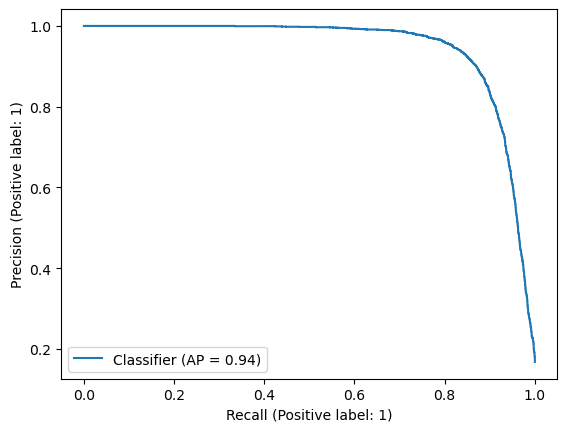

In [71]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true,y_pred)

In [93]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv3/test/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv3/test/false/*.jpg')
df_false.humans = 0

tiled_test = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_39050/2701866335.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_test = df_true.append(df_false)


In [94]:
tiled_test['humans'] = tiled_test.humans.apply(lambda x: str(x))

In [95]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [96]:
def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'

In [97]:
tiled_test

,file_name,humans
0,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/a...,1
1,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/r...,1
2,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/c...,1
3,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/d...,1
4,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/a...,1
...,...,...
11210,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11211,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11212,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11213,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0


In [98]:
tiled_test['prediction'] = tiled_test.file_name.apply(predicter)

In [112]:
tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 

In [113]:
y_true = tiled_test.iloc[:]['humans'].values
y_pred = tiled_test.iloc[:]['prediction'].values

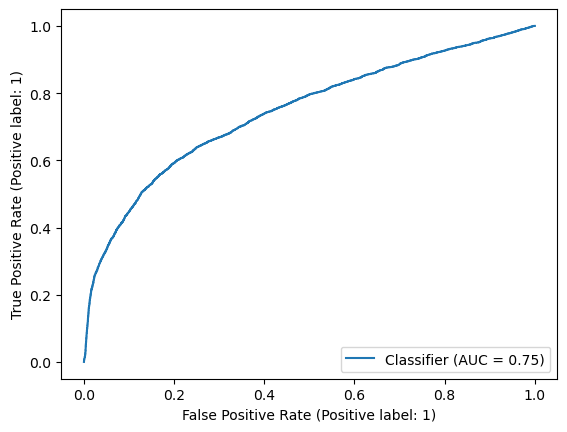

In [114]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred)

In [115]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[8372 2843]
 [1614 2874]]
recall 0.6403743315508021
precision 0.5027112121742172


**model2**

In [147]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/false/*.jpg')
df_false.humans = 0

tiled_test = df_true.append(df_false)

tiled_test['humans'] = tiled_test.humans.apply(lambda x: str(x))

model2 = tf.keras.models.load_model(result_root+'19112022-1728-ResNet+tile+augmentation_10epochs_afo')

def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model2(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'
    
tiled_test['prediction'] = tiled_test.file_name.apply(predicter)

tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 
tiled_test.to_csv(result_root+'19112022-1728-ResNet+tile+augmentation_10epochs_afo/test_prediction.csv')
y_true = tiled_test.iloc[:]['humans'].values
y_pred = tiled_test.iloc[:]['prediction'].values

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_39050/1000422756.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_test = df_true.append(df_false)


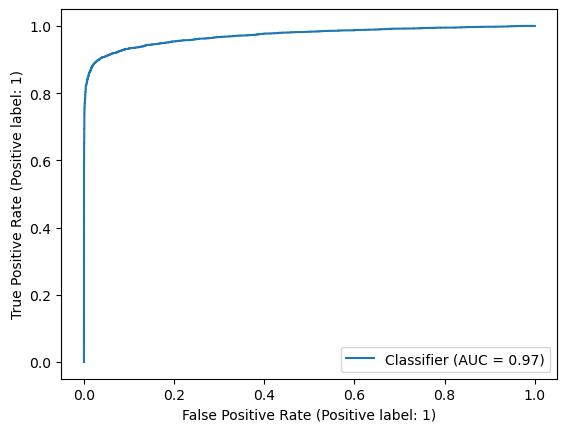

In [118]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred)

In [119]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[11076   139]
 [  620  3868]]
recall 0.8618538324420677
precision 0.9653107062640379


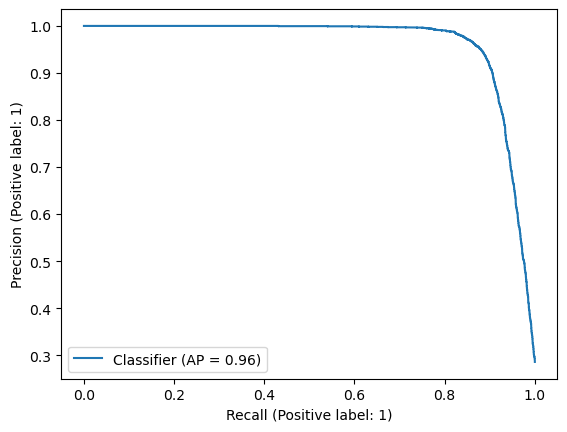

In [148]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true,y_pred)

**model3**


In [128]:
df_true = pd.DataFrame(columns = ['file_name','humans'])
df_false = pd.DataFrame(columns = ['file_name','humans'])

df_true['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/*.jpg')
df_true.humans = 1

df_false['file_name'] = glob.glob(r'/Users/krish/ljmu/1.data/afo/tiledv2/test/false/*.jpg')
df_false.humans = 0

tiled_test = df_true.append(df_false)

/var/folders/zk/p2gyqg915639vx6xr9xbs9cm0000gn/T/ipykernel_39050/2701866335.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tiled_test = df_true.append(df_false)


In [129]:
tiled_test['humans'] = tiled_test.humans.apply(lambda x: str(x))

In [130]:
IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [131]:
def predicter(file_path):
    
    #print(file_path)
    im = Image.open(file_path)
    test_input = np.array(im, dtype=np.uint8)
    if len(test_input.shape) == 3:
        test_input = resize_and_rescale(test_input)
        out = model3(tf.reshape(test_input,(1,224,224,3)))

        return np.array(out)[0][0] 
    else:
        return 'out_of_shape'

In [132]:
tiled_test

,file_name,humans
0,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/a...,1
1,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/r...,1
2,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/c...,1
3,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/d...,1
4,/Users/krish/ljmu/1.data/afo/tiledv2/test/ts/a...,1
...,...,...
11210,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11211,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11212,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0
11213,/Users/krish/ljmu/1.data/afo/tiledv2/test/fals...,0


In [133]:
tiled_test['prediction'] = tiled_test.file_name.apply(predicter)

In [134]:
tiled_test['humans'] = tiled_test.humans.apply(lambda x:int(x)) 

In [135]:
y_true = tiled_test.iloc[:]['humans'].values
y_pred = tiled_test.iloc[:]['prediction'].values

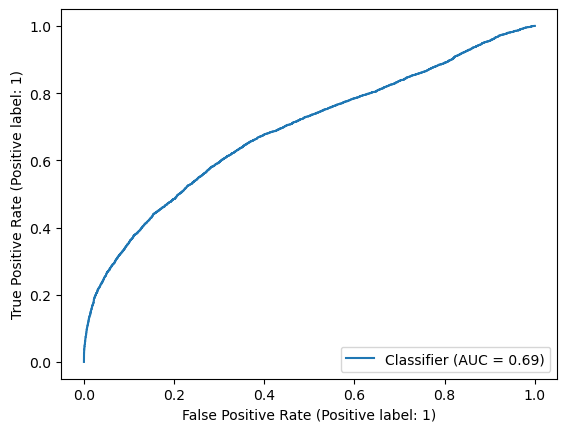

In [136]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_predictions(y_true, y_pred)

In [137]:
from sklearn.metrics import confusion_matrix
print('confusion',confusion_matrix(y_true,y_pred.round()))

from sklearn.metrics import recall_score
print('recall',recall_score(y_true,y_pred.round()))

from sklearn.metrics import precision_score
print('precision',precision_score(y_true,y_pred.round()))

confusion [[3472 7743]
 [ 764 3724]]
recall 0.8297682709447415
precision 0.32475800122089477


In [140]:
from sklearn.metrics import precision_recall_curve
precision_recall_curve(y_true,y_pred)

(array([0.28580526, 0.28582346, 0.28584167, ..., 1.        , 1.        ,
        1.        ]),
 array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        4.45632799e-04, 2.22816399e-04, 0.00000000e+00]),
 array([6.9604104e-04, 1.6842517e-03, 1.7123807e-03, ..., 9.9910921e-01,
        9.9926418e-01, 9.9952912e-01], dtype=float32))

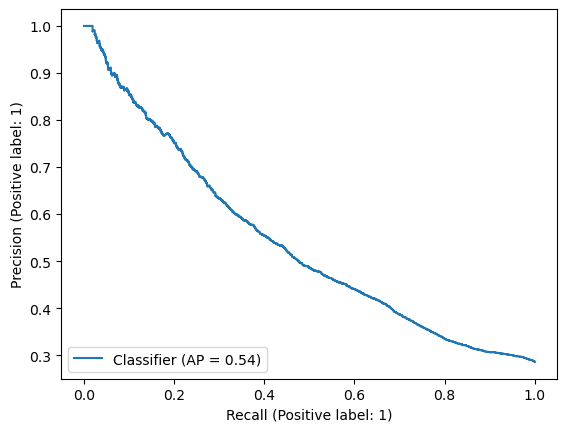

In [145]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(y_true,y_pred)

In [ ]:
# https://stats.stackexchange.com/questions/360017/when-is-an-auc-score-misleadingly-high
When to Use ROC vs. Precision-Recall Curves?
Generally, the use of ROC curves and precision-recall curves are as follows:

ROC curves should be used when there are roughly equal numbers of observations for each class.
Precision-Recall curves should be used when there is a moderate to large class imbalance.
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/#:~:text=ROC%20curves%20are%20appropriate%20when,are%20appropriate%20for%20imbalanced%20datasets.

In [6]:
import sys  
sys.path.insert(0, r'/Users/krish/ljmu/2.code')

import test_modular as th

In [8]:
th.tester()

hi da
